# Implementation for Receipt Matching Data Science Challenge

In [1]:
#Import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split 
import sklearn
from random import shuffle

import xgboost
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Loading the data

In [2]:
df = pd.read_csv('./data/data_interview_test.csv',sep=":")
df.head(100)

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"10,006",10000,"10,217","10,028",0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
96,"10,006",10000,"10,217","10,029",0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
97,"10,007",10000,"10,360","10,348",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
98,"10,007",10000,"10,360","10,349",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Total number of rows 12034 and columns are 14.

### Creating Target labels based on matched and feature transaction ids

In [3]:
df['target']= (df['matched_transaction_id'] == df['feature_transaction_id']).astype(int)


In [4]:
df['target'].value_counts()

0    11177
1      857
Name: target, dtype: int64

The dataset is highly skewed/imbalanced, only 857 correct matches are present.

# EDA-  Data visualization

In [5]:
df.shape

(12034, 15)

In [6]:
df.columns

Index(['receipt_id', 'company_id', 'matched_transaction_id',
       'feature_transaction_id', 'DateMappingMatch', 'AmountMappingMatch',
       'DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
       'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
       'PredictedAmountMatch', 'PredictedTimeCloseMatch', 'target'],
      dtype='object')

In [7]:
df.describe()

,company_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target
count,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000
mean,27247.797906,0.217901,0.031660,0.021522,0.986455,0.013877,0.024215,0.037893,0.753532,0.001005,0.076533,0.071215
std,12024.542988,0.384535,0.122611,0.116995,0.115597,0.116987,0.128646,0.190945,0.430972,0.020134,0.265860,0.257194
min,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,50000.000000,1.000000,0.900000,0.800000,1.000000,1.000000,0.800000,1.000000,1.000000,0.600000,1.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12034 entries, 0 to 12033
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   receipt_id               12034 non-null  object 
 1   company_id               12034 non-null  int64  
 2   matched_transaction_id   12034 non-null  object 
 3   feature_transaction_id   12034 non-null  object 
 4   DateMappingMatch         12034 non-null  float64
 5   AmountMappingMatch       12034 non-null  float64
 6   DescriptionMatch         12034 non-null  float64
 7   DifferentPredictedTime   12034 non-null  float64
 8   TimeMappingMatch         12034 non-null  float64
 9   PredictedNameMatch       12034 non-null  float64
 10  ShortNameMatch           12034 non-null  float64
 11  DifferentPredictedDate   12034 non-null  float64
 12  PredictedAmountMatch     12034 non-null  float64
 13  PredictedTimeCloseMatch  12034 non-null  float64
 14  target                

In [9]:
df.isna().sum()

receipt_id                 0
company_id                 0
matched_transaction_id     0
feature_transaction_id     0
DateMappingMatch           0
AmountMappingMatch         0
DescriptionMatch           0
DifferentPredictedTime     0
TimeMappingMatch           0
PredictedNameMatch         0
ShortNameMatch             0
DifferentPredictedDate     0
PredictedAmountMatch       0
PredictedTimeCloseMatch    0
target                     0
dtype: int64

### Imbalanced Data

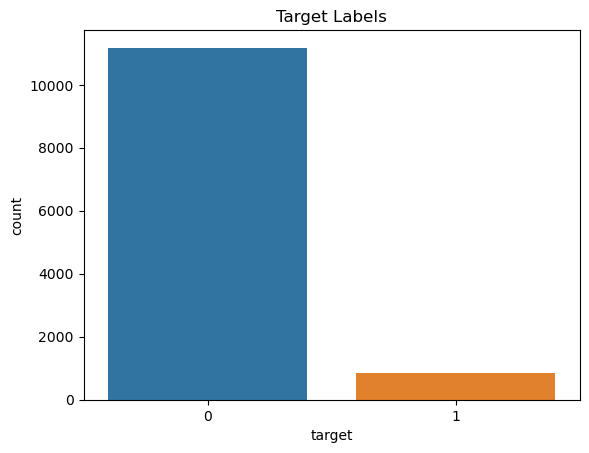

In [10]:
# count of people doing overtime
sns.countplot(df['target'])
fig = plt.gcf()
plt.title('Target Labels')
plt.savefig("./images/output1.png")
plt.show()


# Plot a correlation map for all numeric variables


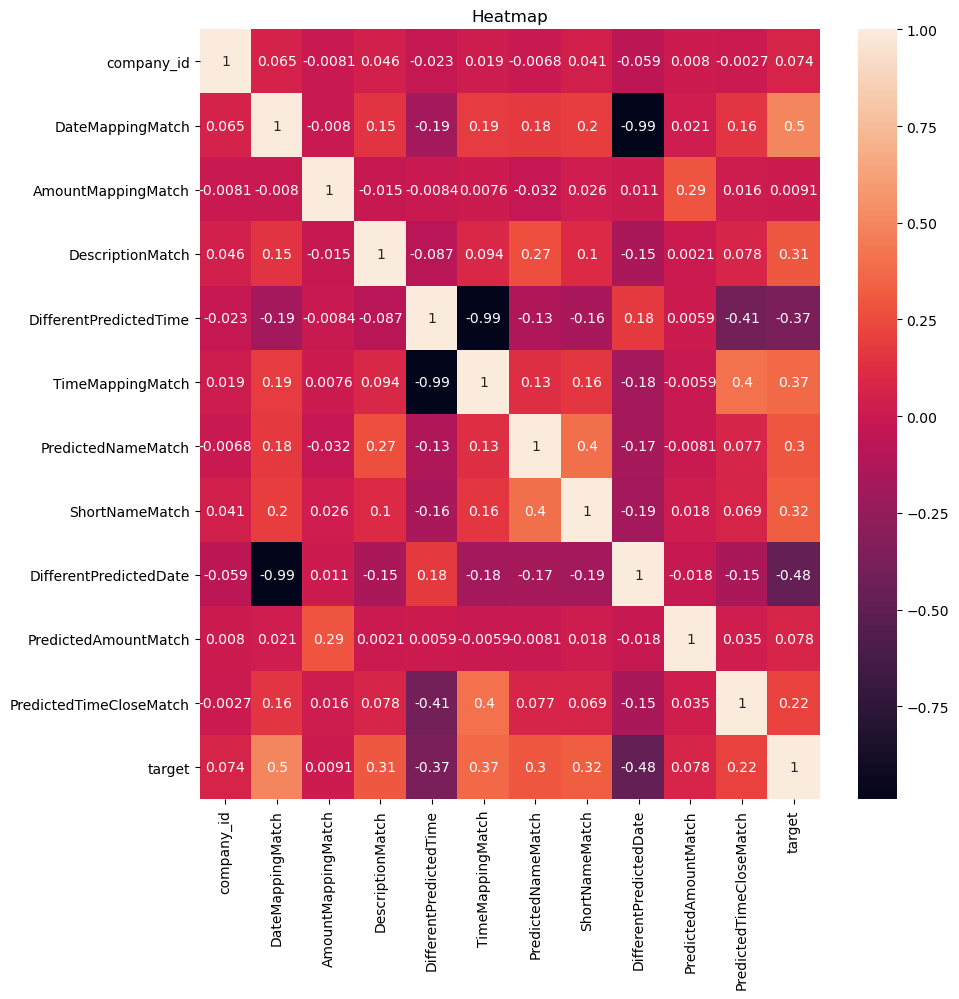

In [11]:
f,ax = plt.subplots(figsize=(10, 10))
a =sns.heatmap(df.corr(), annot=True,ax=ax)
plt.title("Heatmap")
plt.savefig("./images/output2.png")
plt.show()


# DifferentPredictedTime, DifferentPredictedDate can be dropped as they are negatively correlated with respect to target.

In [12]:
df.columns

Index(['receipt_id', 'company_id', 'matched_transaction_id',
       'feature_transaction_id', 'DateMappingMatch', 'AmountMappingMatch',
       'DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
       'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
       'PredictedAmountMatch', 'PredictedTimeCloseMatch', 'target'],
      dtype='object')

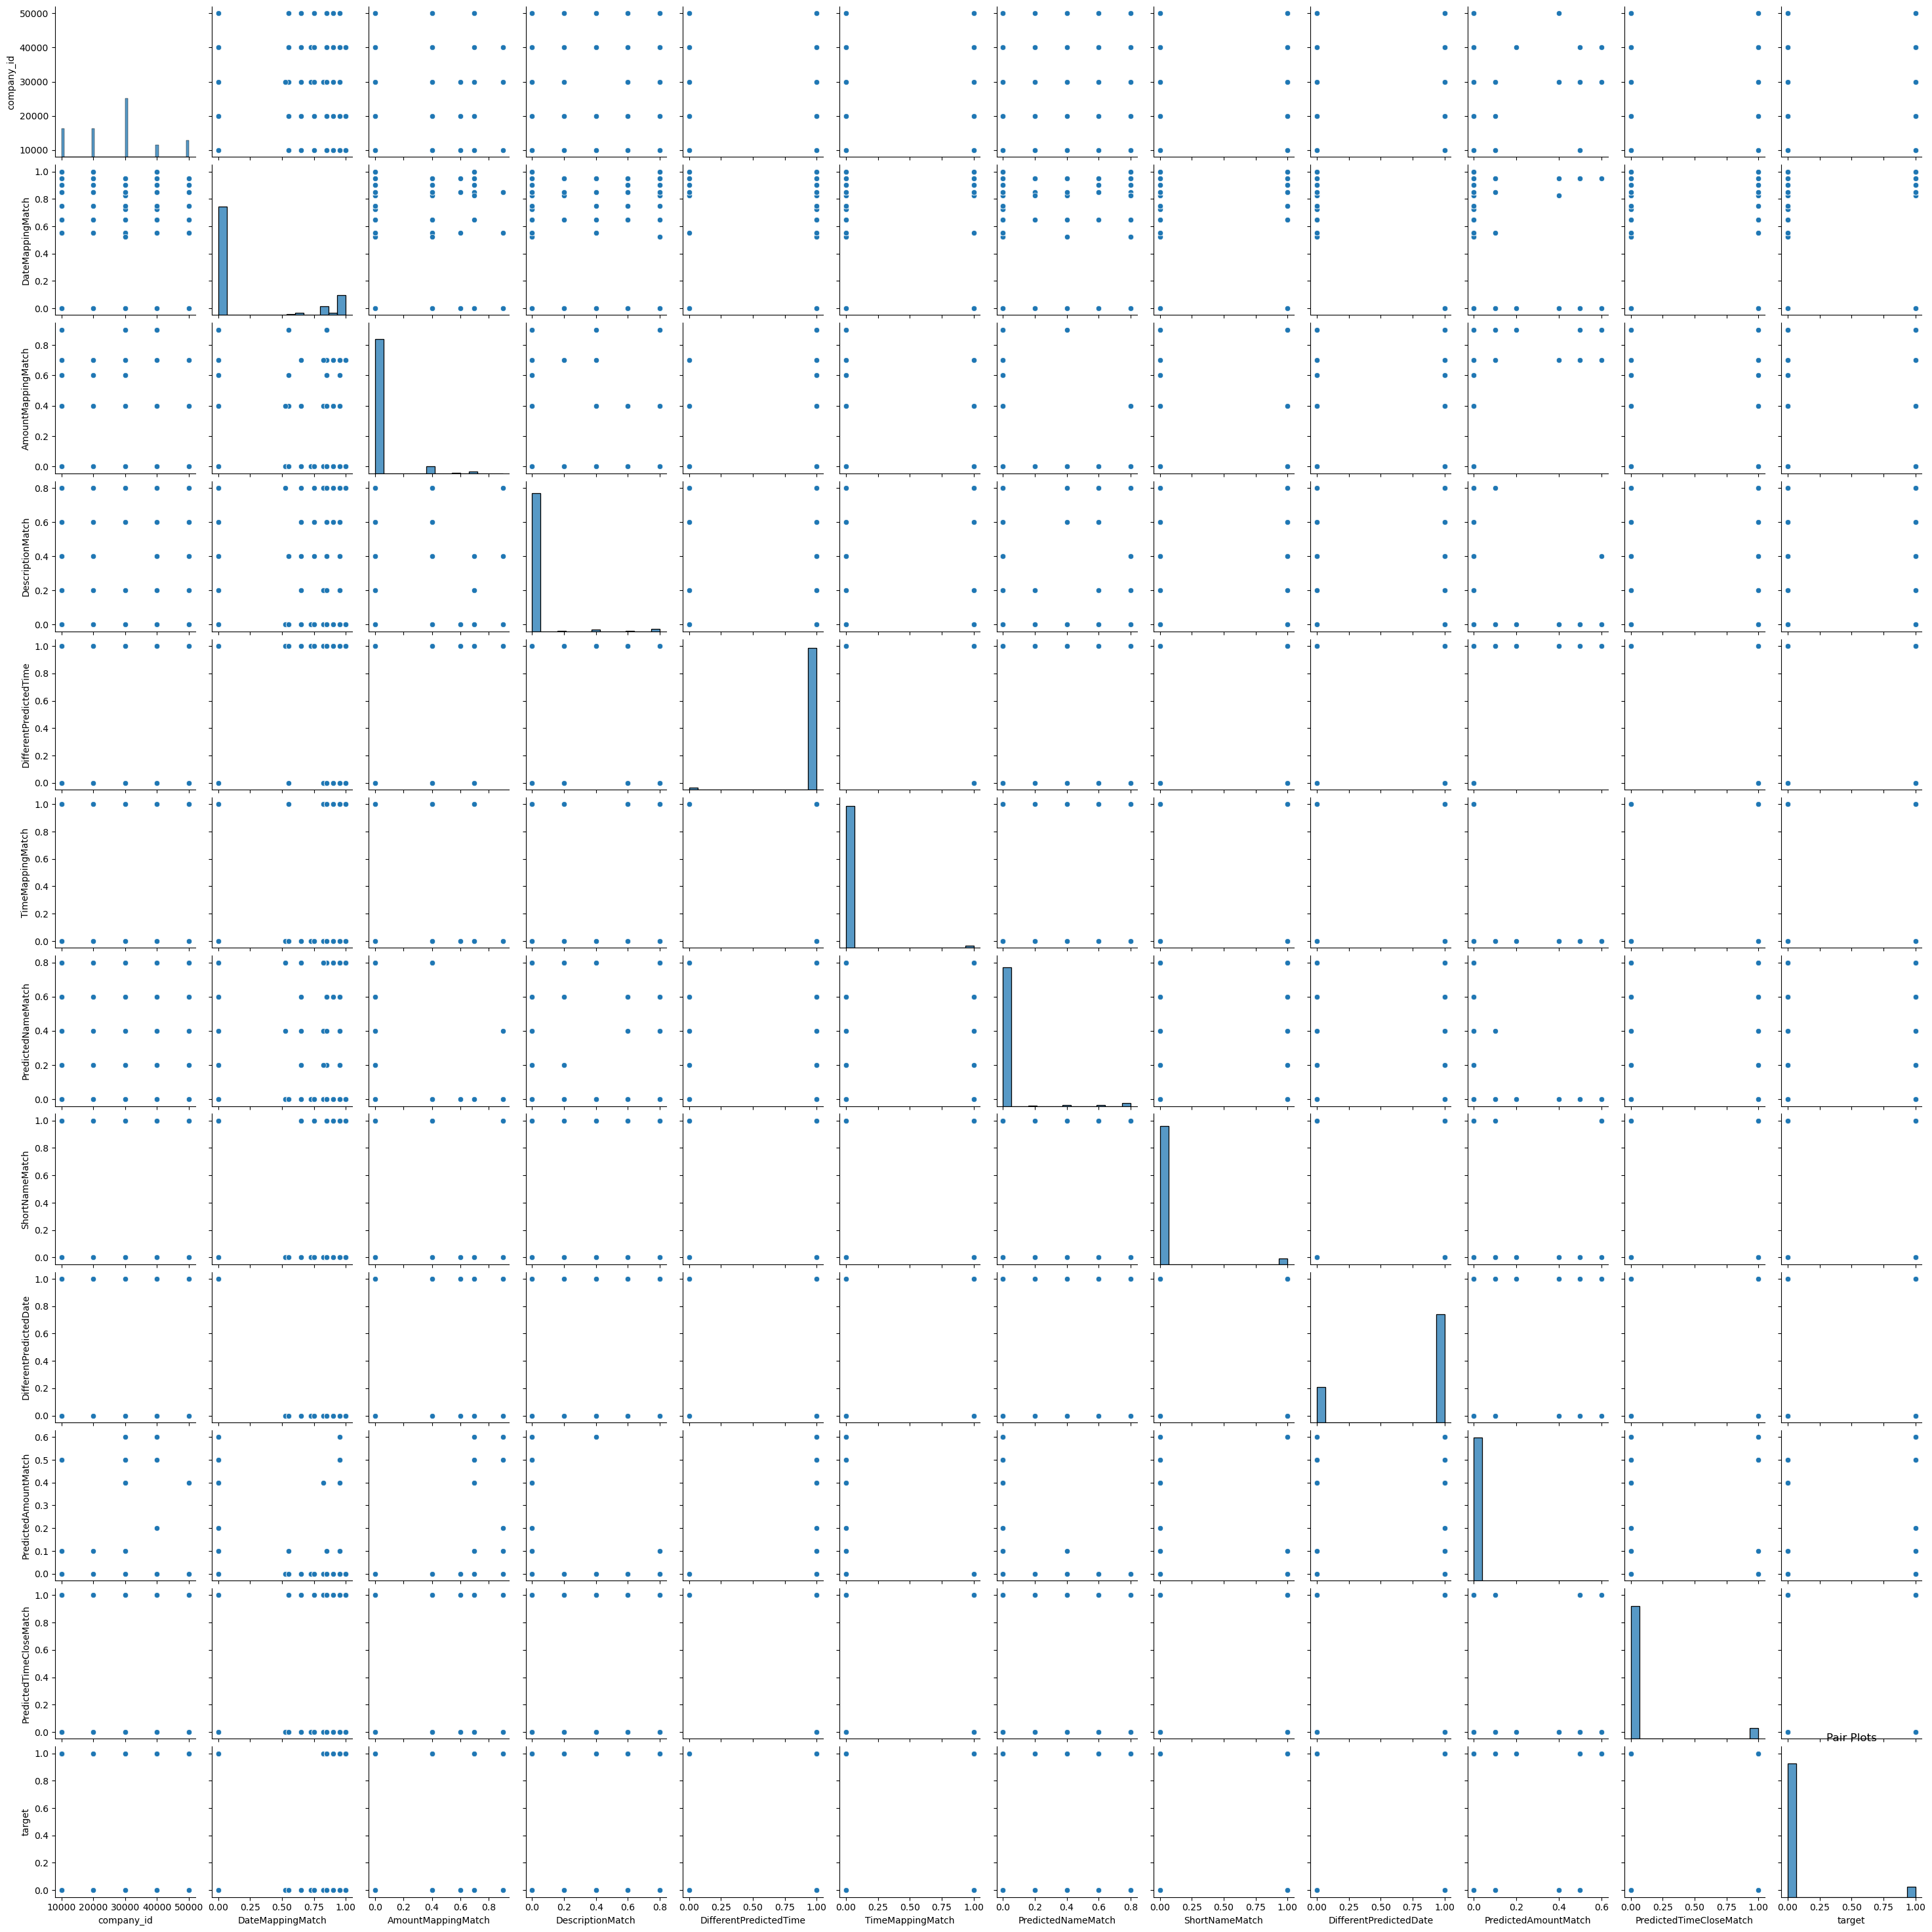

In [13]:
%config InlineBackend.figure_format = 'png'
sns.pairplot(df)
plt.title('Pair Plots')

plt.show()

# Outlier Detection

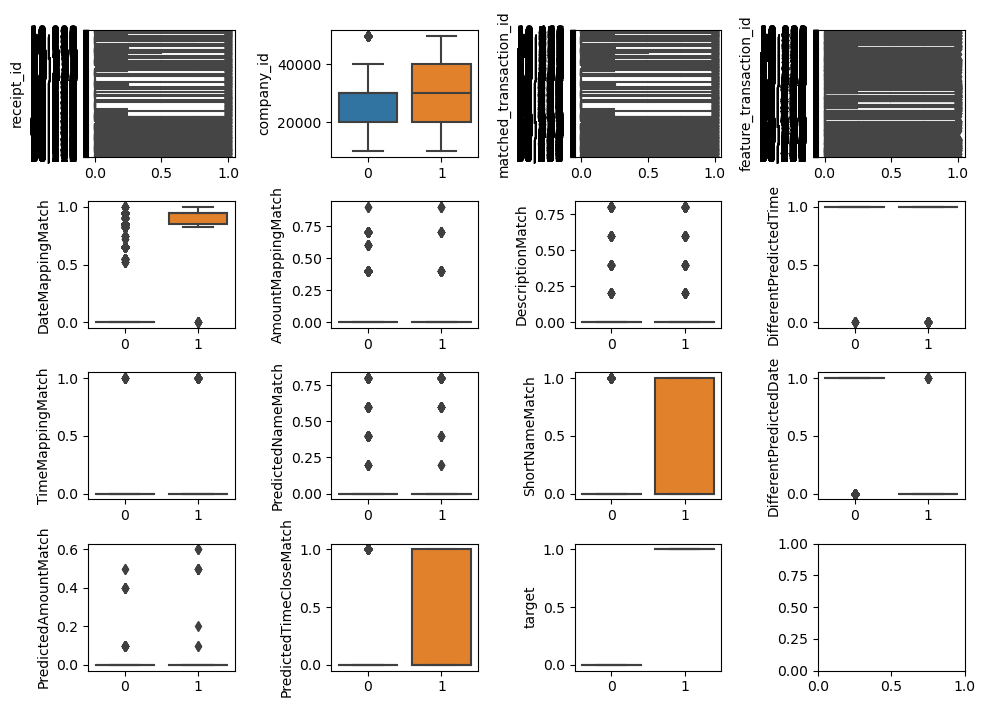

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7))
for idx, feat in enumerate(df.columns):
    ax = axes[int(idx / 4), idx % 4]
    sns.boxplot(x="target", y=feat, data=df, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel(feat)
fig.tight_layout();
plt.show()


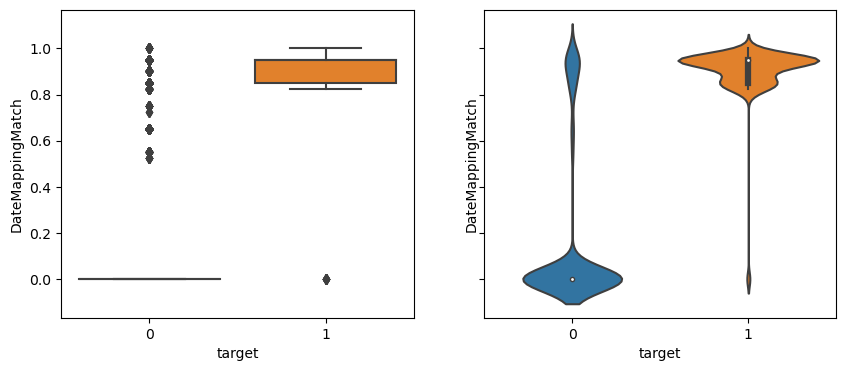

In [15]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

sns.boxplot(x="target", y="DateMappingMatch", data=df, ax=axes[0])
sns.violinplot(x="target", y="DateMappingMatch", data=df, ax=axes[1]);
plt.savefig("./images/output3.png")
plt.show()


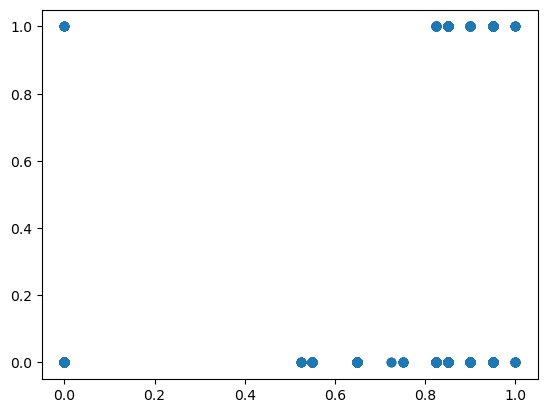

In [16]:
plt.scatter(df["DateMappingMatch"], df["target"])
plt.show()

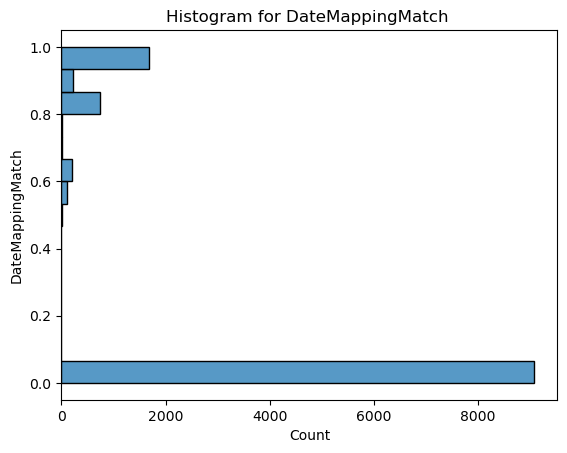

In [17]:
sns.histplot(data=df, y="DateMappingMatch")
fig = plt.gcf()
plt.title('Histogram for DateMappingMatch ')
plt.show()

###DateMappingMatch is 0 for more than 8k samples.


## Evaluation Metric
- As data is imbalanced, Accuracy, precision are bad metrics.
- Recall = true positives/(true positives + false negatives) 
-<b> Recall </b> is metric that we need to consider, the higher the recall the better the model is.. 

## Baseline Models

- Comparision of various spot check algorithms and Ensemble models as baseline.
- Xgboost model produces best result for baseline for imbalanced dataset, hence will be tuning the xgboost model only.


Using Cross validation to see the best  model 

In [18]:
# Test options and evaluation metric
num_folds = 10
seed = np.random.seed
scoring = 'recall'
validation_size = 0.15

In [19]:
df['target']= (df.matched_transaction_id == df.feature_transaction_id).astype(int)
x,y = df[list(df.columns[4:])], df.target
#x=x.drop(['target', 'DifferentPredictedTime','DifferentPredictedDate'], axis=1) 
x=x.drop(['target'], axis=1)  
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=42,shuffle=True)



In [20]:
# Spot-Check Algorithms
models = []
models.append(( ' LR ' , LogisticRegression()))
models.append(( ' LDA ' , LinearDiscriminantAnalysis()))
models.append(( ' KNN ' , KNeighborsClassifier()))
models.append(( ' CART ' , DecisionTreeClassifier()))
models.append(( ' NB ' , GaussianNB()))
models.append(( ' SVM ' , SVC()))

 LR : 0.493255 (0.059528)
 LDA : 0.556068 (0.058471)
 KNN : 0.654873 (0.094477)
 CART : 0.562836 (0.045806)
 NB : 0.608767 (0.042457)
 SVM : 0.575735 (0.039509)


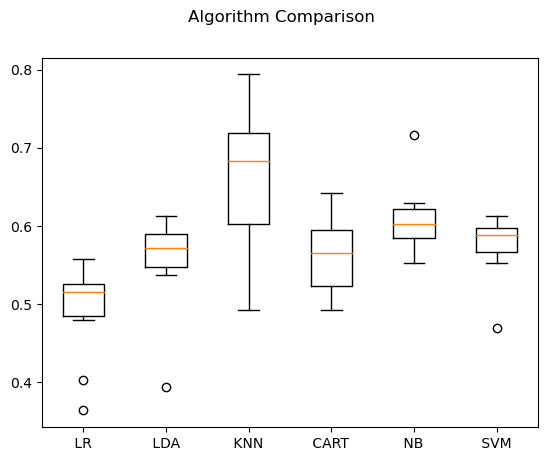

In [21]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='recall')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [22]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LogisticRegression())])))
#pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',
#LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.496093 (0.061754)
ScaledKNN: 0.708282 (0.045359)
ScaledCART: 0.564449 (0.047782)
ScaledNB: 0.608767 (0.042457)
ScaledSVM: 0.600359 (0.036818)


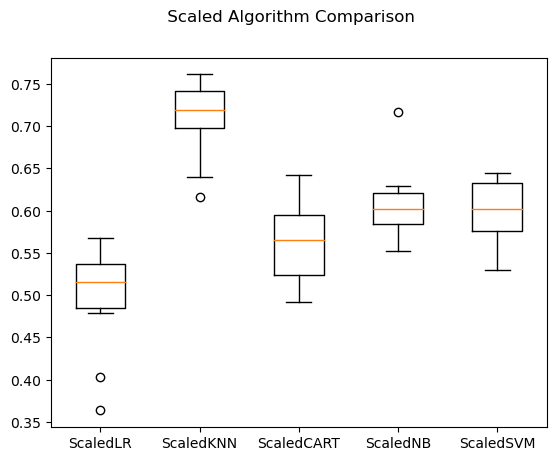

In [23]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( ' Scaled Algorithm Comparison ' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig("./images/output4.png")

plt.show()


In [24]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

AB: 0.545991 (0.052107)
GBM: 0.600334 (0.037059)
RF: 0.568366 (0.048254)
ET: 0.569736 (0.047848)


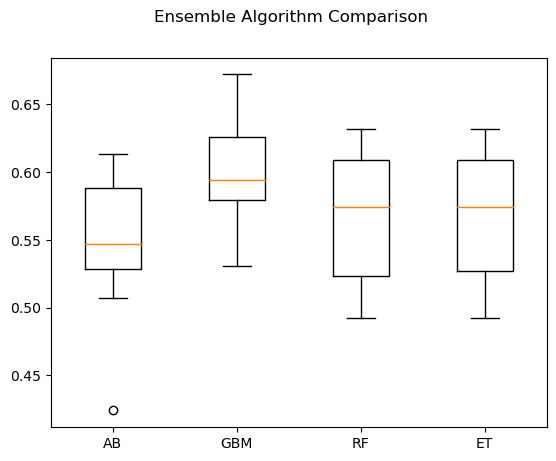

In [25]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig("./images/output5.png")

plt.show()


In [26]:
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())])))
out=[]
Names =[]

In [27]:
for Name, algos in ensembles:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(algos, X_train, Y_train, cv=kfold, scoring=scoring)
	out.append(cv_results)
	Names.append(Name)
	msg = "%s: %f (%f)" % (Name, cv_results.mean(), cv_results.std())
	print(msg)

ScaledAB: 0.545991 (0.052107)
ScaledGBM: 0.600334 (0.037059)
ScaledRF: 0.569736 (0.047848)
ScaledET: 0.571376 (0.048237)


##### Fine tunning KNN

In [28]:
# Tune scaled KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.708282 using {'n_neighbors': 5}
0.707859 (0.079968) with: {'n_neighbors': 1}
0.494852 (0.058690) with: {'n_neighbors': 3}
0.708282 (0.045359) with: {'n_neighbors': 5}
0.572587 (0.040052) with: {'n_neighbors': 7}
0.562292 (0.037414) with: {'n_neighbors': 9}
0.556461 (0.037194) with: {'n_neighbors': 11}
0.559675 (0.048180) with: {'n_neighbors': 13}
0.564753 (0.039706) with: {'n_neighbors': 15}
0.563114 (0.040972) with: {'n_neighbors': 17}
0.573014 (0.045193) with: {'n_neighbors': 19}
0.580898 (0.043265) with: {'n_neighbors': 21}


# USE OF XGBOOST

Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. 

# FEATURE IMPORTANCE USING XGBOOST

Feature: 0, Score: 0.24736
Feature: 1, Score: 0.00895
Feature: 2, Score: 0.06862
Feature: 3, Score: 0.49661
Feature: 4, Score: 0.04592
Feature: 5, Score: 0.02687
Feature: 6, Score: 0.06265
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.02825
Feature: 9, Score: 0.01476


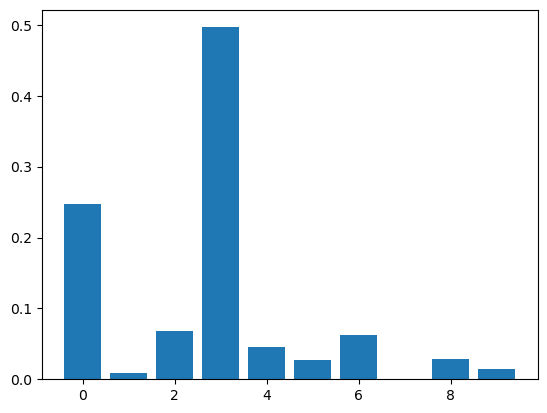

In [29]:
from xgboost import XGBClassifier

model = XGBClassifier()
# fit the model
model.fit(X_train, Y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.savefig("./images/output6.png")
plt.show()



In [30]:
train = xgboost.DMatrix(X_train, label=Y_train)
test = xgboost.DMatrix(X_test, label=Y_test)
watchlist = [(test, 'eval'), (train, 'train')]

xgb_params = {
            'objective': 'binary:logistic',
            'tree_method': 'gpu_hist',
            'max_depth': 2, 
            'eta':0.1,
            'subsample':0.5,
            'colsample_bytree': 0.05,
            
}

clf = xgboost.train( xgb_params,train, num_boost_round=10000, )

preds = clf.predict(test)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2789
           1       0.81      0.62      0.70       220

    accuracy                           0.96      3009
   macro avg       0.89      0.80      0.84      3009
weighted avg       0.96      0.96      0.96      3009

 In the Confusion Matrix below, the digonal values represent correct classification for each class : 


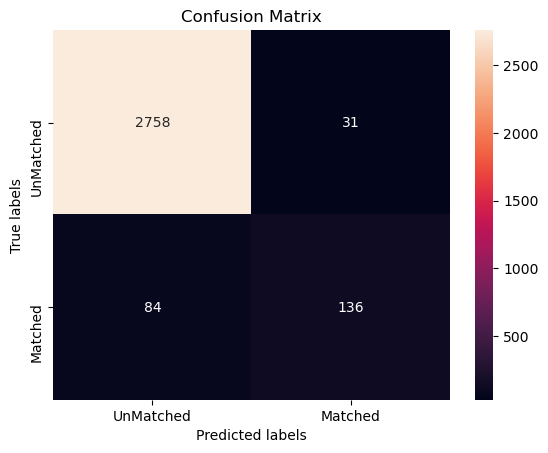

In [31]:
print(classification_report((Y_test),preds.round(0)))
print( " In the Confusion Matrix below, the digonal values represent correct classification for each class : ")
labels = ['UnMatched', 'Matched']

cm = sklearn.metrics.confusion_matrix((Y_test),(preds.round(0).astype(int)))
 

ax= plt.subplot()
sns.heatmap(cm.astype(int), annot=True,fmt='g', ax = ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.savefig("./images/output7.png")
plt.show()


- The XBOOST has decent recall, precision when compared with others. 


### Improving XGBOOST

              precision    recall  f1-score   support

           0       1.00      0.84      0.92      2789
           1       0.33      0.99      0.50       220

    accuracy                           0.85      3009
   macro avg       0.67      0.92      0.71      3009
weighted avg       0.95      0.85      0.88      3009



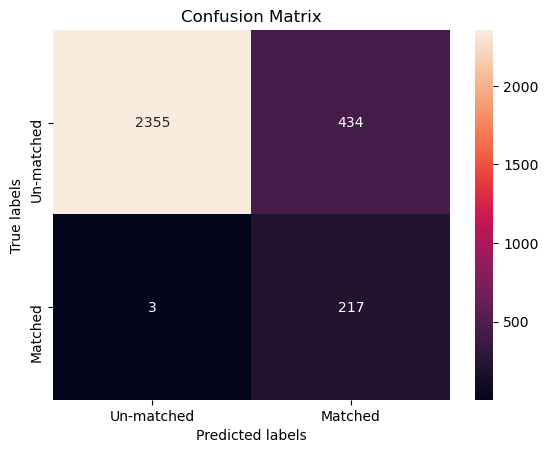

In [34]:

train = xgboost.DMatrix(X_train, label=Y_train)
test = xgboost.DMatrix(X_test, label=Y_test)
watchlist = [(test, 'eval'), (train, 'train')]

xgb_params = {
            'objective': 'binary:logistic',
            'tree_method': 'gpu_hist',
            'max_depth': 2, 
            'eta':0.1,
            'subsample':0.5,
            'colsample_bytree': 0.05,
            'scale_pos_weight':8,
}

clf = xgboost.train( xgb_params,train )

preds = clf.predict(test)

print(classification_report((Y_test),preds.round(0)))

labels = ['Un-matched', 'Matched']

cm = sklearn.metrics.confusion_matrix((Y_test),(preds.round(0).astype(int)))
 

ax= plt.subplot()
sns.heatmap(cm.astype(int), annot=True,fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.savefig("./images/output8.png")
plt.show()


- scale_pos_weight is the ratio of number of negative class to the positive class.
- this improves the recall value significantly to 0.99.. 

In [33]:
import pickle
file_name = "./model/xgb_model.pkl"
pickle.dump(clf, open(file_name, "wb"))

### Future steps:
- Hyperparameter optimization of XGBOOST, to improve the metrics further.
- Use of Oversampling/ undersampling technniques to balance the dataset.
- Use of deep learning based approaches for larger dataset.


### Conclusion:

- Recall is chosen as the main evaluation metric to consider.
- Hyper-Parameter optimization for Xgboost and others might not significantly improve the results as the dataset is imbalanced.
- Dropping negative correlated features/ outliers didnt produce better results.
- Data transformation might be needed after understanding of each of the column features.
- Dimensionality reduction / DL based approaches can be explored. 
